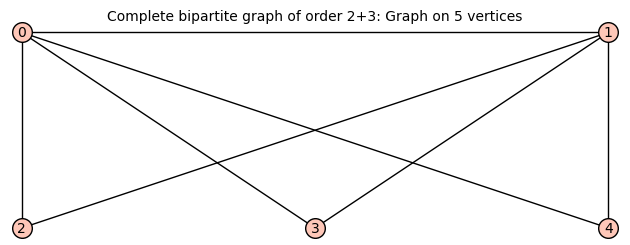

In [1]:
n = 3

graph = graphs.CompleteBipartiteGraph(2, n)
graph.add_edge(0, 1)
edgelist = graph.edges(labels=False)
matroid = Matroid(graph=edgelist, groundset=edgelist)
len(edgelist)
graph

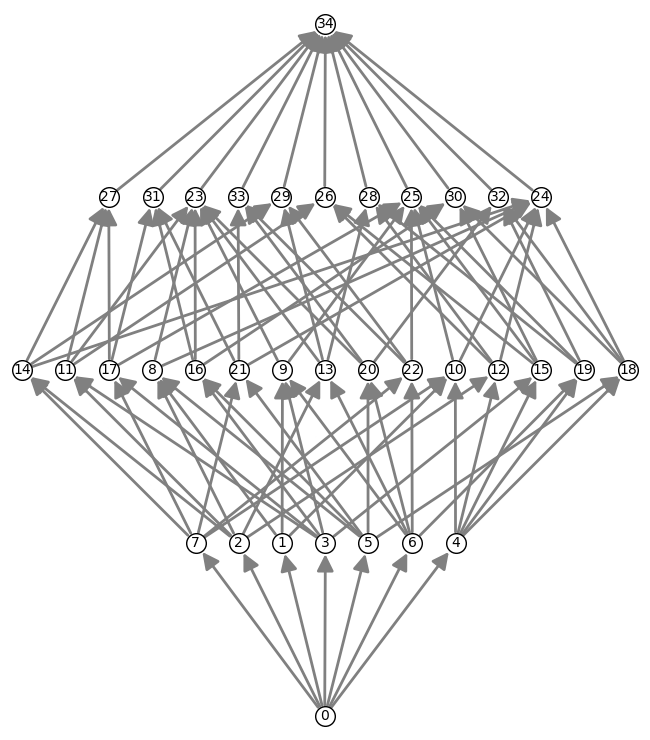

In [439]:
rank = matroid.rank()

flats = [list(matroid.flats(i)) for i in range(rank + 1)]
all_elements = sum(flats, [])  # Flatten the list of flats
labels = {element: idx for idx, element in enumerate(all_elements)}
matroid.lattice_of_flats().plot(
    element_labels = labels, element_color = "white",
    figsize= 10, cover_color = "grey")

In [440]:
def generate_weights(rank):
    weights = set() 
    for i in range(1, rank):
        for j in range(rank):
            weight = [0] * rank
            
            if i >= j:
                weight[i] = j
                weights.add(tuple(weight))

            if rank - (i+1) > 1:
                # Recursion to get the complete list of weights...
                y = generate_weights(rank - (i + 1)) 
                for x in y:
                    temp_weight = weight.copy()
                    weights.add(tuple(temp_weight[:i+1] + x)) 

    return [list(w) for w in weights]

weights = generate_weights(rank)

In [441]:
rflats = flats[1:] #empty flat is not required.
fy_monomials_list = [[] for _ in range(rank)]

def generate_monomials(weight, flats):
    if sum(weight) == 0: return [[]]
    # Find the first non-zero weight
    start_index = next(i for i in range(len(weight)) if weight[i] != 0)
    result = []

    for initial_flat in flats[start_index]:
        initial_monomial = [initial_flat] * weight[start_index]
        potential_combinations = [initial_monomial]

        for i in range(start_index + 1, len(weight)):
            if weight[i] != 0:
                new_combinations = []
                for flat in flats[i]:
                    for combo in potential_combinations:
                        if combo[-1].issubset(flat):
                            new_combo = combo + [flat] * weight[i]
                            new_combinations.append(new_combo)
                potential_combinations = new_combinations

        result.extend(potential_combinations)

    return result

for weight in weights:
    fy_monomials_list[sum(weight)].extend(generate_monomials(weight, rflats))

#example fy-monomial
print(fy_monomials_list[2][0])

[frozenset({(0, 1), (0, 2), (1, 2)}), frozenset({(0, 1), (0, 2), (1, 2), (0, 4), (0, 3), (1, 3), (1, 4)})]


In [442]:
def simplify(monomial):
    return tuple(sorted([labels[x] for x in monomial]))

def set_simplify(monomial_set):
    return set(sorted([simplify(x) for x in monomial_set]))

In [443]:
g = SymmetricGroup(range(n+2))
transpositions = set([(0,1)] + [(i, i+1) for i in range(2, n+1)])
grp = g.subgroup(transpositions)
print(grp.list())

def action_on_flats(g, m):
    def action_on_groundset(g, x):
        return tuple(sorted(g(y) for y in x))
    return frozenset(sorted([action_on_groundset(g,x) for x in m]))

def action_on_braidfymonomials(g, monomial):
    return tuple(sorted([action_on_flats(g,m) for m in monomial]))

def stab(G, m, action):
    return G.subgroup(set(g for g in G if action(g, m) == tuple(m)))

def orbit(G, m, action):
    return frozenset(sorted([action(g, m) for g in G]))
    
def orbits(G, X, action):
    return set(orbit(G, x, action) for x in X)

[(), (2,3,4), (2,4,3), (3,4), (2,3), (2,4), (0,1), (0,1)(2,3,4), (0,1)(2,4,3), (0,1)(3,4), (0,1)(2,3), (0,1)(2,4)]


In [444]:
fy_monomials_orbits = [orbits(grp, fy_monomials_list[i], action_on_braidfymonomials)
    for i in range(rank)
    ]

print(fy_monomials_orbits)

orbits_dict = {}
for idx, orbit_set in enumerate(fy_monomials_orbits):
    print(f"\ndegree: {idx}")
    for x in orbit_set:
        orbits_dict[x] = len(orbits_dict)
        print(f"{orbits_dict[x]}: {set_simplify(x)}\n")



[{frozenset({()})}, {frozenset({(frozenset({(0, 1), (1, 2), (0, 4), (1, 4), (0, 2)}),), (frozenset({(0, 1), (0, 4), (0, 3), (1, 4), (1, 3)}),), (frozenset({(0, 1), (1, 2), (0, 3), (0, 2), (1, 3)}),)}), frozenset({(frozenset({(0, 2), (1, 4)}),), (frozenset({(0, 3), (1, 4)}),), (frozenset({(1, 3), (0, 4)}),), (frozenset({(1, 2), (0, 3)}),), (frozenset({(1, 2), (0, 4)}),), (frozenset({(0, 2), (1, 3)}),)}), frozenset({(frozenset({(0, 2), (0, 3), (0, 4)}),), (frozenset({(1, 2), (1, 3), (1, 4)}),)}), frozenset({(frozenset({(0, 1), (1, 2), (0, 4), (0, 3), (1, 4), (0, 2), (1, 3)}),)}), frozenset({(frozenset({(1, 3), (1, 2), (0, 4)}),), (frozenset({(0, 2), (0, 3), (1, 4)}),), (frozenset({(0, 2), (1, 3), (1, 4)}),), (frozenset({(1, 2), (0, 3), (1, 4)}),), (frozenset({(1, 2), (0, 3), (0, 4)}),), (frozenset({(1, 3), (0, 2), (0, 4)}),)}), frozenset({(frozenset({(0, 3), (0, 4)}),), (frozenset({(1, 2), (1, 4)}),), (frozenset({(0, 2), (0, 3)}),), (frozenset({(1, 3), (1, 4)}),), (frozenset({(1, 2), (1,

In [445]:
for orbits in fy_monomials_orbits:
    fn = ClassFunction(grp, [0] * len(grp.conjugacy_classes()))
    orbits_simplify = {orbits_dict[orbit] for orbit in orbits}

    for orbit in orbits:
        orbit_num = orbits_dict[orbit]
        orbit_stab = stab(grp, tuple(orbit)[0], action_on_braidfymonomials)
        print(f"Orbit {orbit_num} is stabilized by a subgroup of order {orbit_stab.order()}")
        fn += orbit_stab.trivial_character().induct(grp)

    print(f"\nThe permutation representation for {orbits_simplify} is")
    for x, y in fn.decompose():
        print(f"{x} copies of {list(y.values())}")
    print("\n")

Orbit 0 is stabilized by a subgroup of order 12

The permutation representation for {0} is
1 copies of [1, 1, 1, 1, 1, 1]


Orbit 1 is stabilized by a subgroup of order 4
Orbit 2 is stabilized by a subgroup of order 2
Orbit 3 is stabilized by a subgroup of order 6
Orbit 4 is stabilized by a subgroup of order 12
Orbit 5 is stabilized by a subgroup of order 2
Orbit 6 is stabilized by a subgroup of order 2
Orbit 7 is stabilized by a subgroup of order 4

The permutation representation for {1, 2, 3, 4, 5, 6, 7} is
1 copies of [1, -1, 1, -1, 1, -1]
3 copies of [1, 1, 1, -1, -1, -1]
7 copies of [1, 1, 1, 1, 1, 1]
3 copies of [2, 0, -1, -2, 0, 1]
5 copies of [2, 0, -1, 2, 0, -1]


Orbit 8 is stabilized by a subgroup of order 6
Orbit 9 is stabilized by a subgroup of order 12
Orbit 10 is stabilized by a subgroup of order 2
Orbit 11 is stabilized by a subgroup of order 4
Orbit 12 is stabilized by a subgroup of order 4
Orbit 13 is stabilized by a subgroup of order 2
Orbit 14 is stabilized by a sub